# Settings

In [ ]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Google Drive Mount

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 必要なライブラリのインストール

In [ ]:
import warnings
warnings.simplefilter('ignore')

import os
import gc
gc.enable()
import sys
import glob
import math
import time
import random

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import mean_squared_error

from datetime import datetime
from tqdm.auto import tqdm as tqdmp
from tqdm.autonotebook import tqdm as tqdm
tqdmp.pandas()

# import lightly

# TTA
# import ttach as tta

# Config

In [ ]:
class CFG:
  def __init__(self):

      self.wandb = False
      self.debug = False
      self.early_stop_flg = True
      self.early_stop_round = 4
      self.exp_name = '136_exp'
      self.seed = 55
      self.n_fold = 4
      self.num_workers = 1
      self.model_name = 'vit_large_patch16_384'
      self.mode = 'Classification'
      self.padding = False
      self.multitask = False
      self.SSL = False
      self.size = 384
      self.fold = []

      self.epochs = 10
      self.batch_size = 2
      self.lr = 1e-5
      self.weight_decay = 1e-6
      self.scheduler = 'scheduler:CosineAneelingLR'
      self.eta_min = 0
      self.T_max = self.epochs
      self.MIXUP = False
      self.TTA = False
      self.alpha = 1.0
      self.n_tta = 10
      self.accumulation_steps = 8
      self.N_MSD = 10
      self.MIXOUT = 0.5

CONFIG = CFG()

In [ ]:
def seed_everything(seed:int==42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CONFIG.seed)

## Data Load

In [ ]:
INPUT_DIR = "/content/drive/MyDrive/nihonga/data/"

EXP_NAME = f'{CONFIG.exp_name}'
OUTPUT_DIR = f'/content/drive/MyDrive/nihonga/interim/{EXP_NAME}/'
MODEL_DIR = f'/content/drive/MyDrive/nihonga/model/{EXP_NAME}/'
OOF_DIR = f'/content/drive/MyDrive/nihonga/oof/{EXP_NAME}/'
SUB_DIR = f'/content/drive/MyDrive/nihonga/sub/{EXP_NAME}/'

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(OOF_DIR, exist_ok=True)
os.makedirs(SUB_DIR, exist_ok=True)

print(f'INPUT_DIR: {INPUT_DIR}')
print(f'OUTPUT_DIR: {OUTPUT_DIR}')
print(f'MODEL_DIR: {MODEL_DIR}')
print(f'OOF_DIR: {OOF_DIR}')
print(f'SUB_DIR: {SUB_DIR}')

INPUT_DIR: /content/drive/MyDrive/nihonga/data/
OUTPUT_DIR: /content/drive/MyDrive/nihonga/interim/136_exp/
MODEL_DIR: /content/drive/MyDrive/nihonga/model/136_exp/
OOF_DIR: /content/drive/MyDrive/nihonga/oof/136_exp/
SUB_DIR: /content/drive/MyDrive/nihonga/sub/136_exp/


In [ ]:
train_img = np.load(os.path.join(INPUT_DIR,
                                'train_data.npz'))
test_img = np.load(os.path.join(INPUT_DIR,
                                'test_data.npz'))
sub_df = pd.read_csv(os.path.join(INPUT_DIR,
                                'submission.csv'))

In [ ]:
train_df = pd.DataFrame(range(6446),columns=['id'])
train_df['label'] = train_img['arr_1']
test_df = pd.DataFrame(range(test_img['arr_0'].shape[0]),columns=['id'])
if CONFIG.debug:
    train_df = train_df.head(100)
    test_df = test_df.head(50)

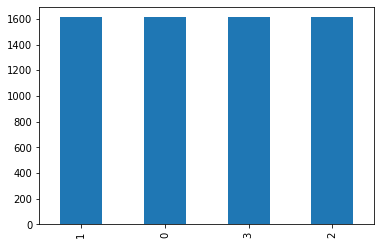

In [ ]:
train_df['fold'] = -1
strat_kfold = StratifiedKFold(n_splits=CONFIG.n_fold, random_state=CONFIG.seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['label'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

### Optuna(Selected)

In [ ]:
noc_df = pd.read_csv(os.path.join(INPUT_DIR,
                                'oof_whole_df_v2.csv'))
no_chance_list = noc_df[noc_df['no_chance']==1].index
no_chance_list
not_no_chance = list(set(train_df.index) - set(no_chance_list))

In [ ]:
from sklearn.metrics import f1_score

def get_score(y_true, y_pred):
    score = f1_score(y_true, y_pred,average='macro')
    return score

In [ ]:
!pip install optuna -Uq

     |████████████████████████████████| 308 kB 7.5 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████████████████████████| 209 kB 61.7 MB/s 
     |████████████████████████████████| 78 kB 8.5 MB/s 
     |████████████████████████████████| 147 kB 64.1 MB/s 
     |████████████████████████████████| 49 kB 6.9 MB/s 
     |████████████████████████████████| 112 kB 78.0 MB/s 


In [ ]:
oof_dict = {
    '57':'/content/drive/MyDrive/nihonga/oof/057_exp/057_exp_oof_preds_0.87841.csv', # swin_large × CutMix
    '62':'/content/drive/MyDrive/nihonga/oof/062_exp/062_exp_oof_preds_0.86057.csv', # DINO vit_base
    '69':'/content/drive/MyDrive/nihonga/oof/069_exp/069_exp_oof_preds_0.89750.csv', # swin_large × Pseudo
    '71':'/content/drive/MyDrive/nihonga/oof/071_exp/071_exp_oof_preds_0.87404.csv', # DINO × ImageNet × vit_base
    '72':'/content/drive/MyDrive/nihonga/oof/072_exp/072_exp_oof_preds_0.90127.csv', # vit_large × Pseudo
    '77':'/content/drive/MyDrive/nihonga/oof/077_exp/077_exp_oof_preds_0.88019.csv',  # swin_large × fold 8
    '80':'/content/drive/MyDrive/nihonga/oof/080_exp/080_exp_oof_preds_0.89421.csv',  # vit_large except_no_chance
    '90':'/content/drive/MyDrive/nihonga/oof/090_exp/090_exp_oof_preds_0.86506.csv',  # vit_large no Rotate ShiftScaleRotate
    '91':'/content/drive/MyDrive/nihonga/oof/091_exp/091_exp_oof_preds_0.86952.csv',  # vit_large Clustering
}

oof = np.zeros((len(oof_dict), train_df.loc[not_no_chance].shape[0], 4))

for i in range(oof.shape[0]):
    df = pd.read_csv(list(oof_dict.values())[i]).rename(columns={'label_0':'prob_cls0','label_1':'prob_cls1','label_2':'prob_cls2','label_3':'prob_cls3'})
    if list(oof_dict.keys())[i] in ['80']:
      oof[i] = df.loc[:,['prob_cls0','prob_cls1','prob_cls2','prob_cls3']]
    else:
      oof[i] = df.loc[not_no_chance,['prob_cls0','prob_cls1','prob_cls2','prob_cls3']]#.reset_index(drop=True)

In [ ]:
from numba import njit
def log_loss_numpy(y_true, y_pred):


    assert y_true.shape == (6371, ) # y_trainと同じ型
    assert y_pred.shape == (6371, 4) # (data_size, num_classes)

    y_true_ravel = np.asarray(y_true).ravel()
    y_pred_ravel = np.asarray(np.argmax(y_pred, axis=1)).ravel()
    loss = -f1_score(y_true_ravel, y_pred_ravel, average="macro")

    return loss.mean()

In [ ]:
log_loss_scores = {}
oof_23 = pd.read_csv('/content/drive/MyDrive/nihonga/oof/023_exp/023_exp_oof_preds_0.86753.csv')
y_train = oof_23.loc[not_no_chance,'label'].values

for n, key in enumerate(oof_dict):
    score_oof = log_loss_numpy(y_train, oof[n])
    # log_loss_scores[key] = score_oof
    print(f'{key} CV:\t', score_oof)

57 CV:	 -0.8911836922132945
62 CV:	 -0.8733256793129479
69 CV:	 -0.9109026496181284
71 CV:	 -0.886062875516114
72 CV:	 -0.9142335994735787
77 CV:	 -0.892108158367602
80 CV:	 -0.8942121511712662
90 CV:	 -0.876383021026518
91 CV:	 -0.8810683123644206


In [ ]:
def objective(trial):

    """
    trialで条件設定. returnにはscoreを設定.
    """

    w_0 = trial.suggest_uniform('057', 0, 1)
    w_1 = trial.suggest_uniform('062', 0, 1)
    w_2 = trial.suggest_uniform('069', 0, 1)
    w_3 = trial.suggest_uniform('071', 0, 1)
    w_4 = trial.suggest_uniform('072', 0, 1)
    w_5 = trial.suggest_uniform('077', 0, 1)
    w_6 = trial.suggest_uniform('080', 0, 1)
    w_7 = trial.suggest_uniform('090', 0, 1)
    w_8 = trial.suggest_uniform('091', 0, 1)

    pred_0 = oof[0]
    pred_1 = oof[1]
    pred_2 = oof[2]
    pred_3 = oof[3]
    pred_4 = oof[4]
    pred_5 = oof[5]
    pred_6 = oof[6]
    pred_7 = oof[7]
    pred_8 = oof[8]

    pred = (
        w_0*pred_0 + w_1*pred_1 + w_2*pred_2 + w_3*pred_3 + w_4*pred_4 + w_5*pred_5 + w_6*pred_6 + w_7*pred_7 + w_8*pred_8) / 9

    score = f1_score(y_train, np.argmax(pred, axis=1), average="macro")

    return score

In [ ]:
# Optuna
import optuna
study1 = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=CONFIG.seed))
optuna.logging.set_verbosity(0)
study1.optimize(objective, n_trials=None, timeout=3600 , show_progress_bar=True)

[I 2022-08-07 10:06:18,933] A new study created in memory with name: no-name-8f683d02-3097-4f15-9ff7-5c2c31895684


0it [00:00, ?it/s]

In [ ]:
study1.best_trial, study1.best_value

(FrozenTrial(number=4082, values=[0.9248963284128384], datetime_start=datetime.datetime(2022, 8, 7, 10, 20, 45, 654878), datetime_complete=datetime.datetime(2022, 8, 7, 10, 20, 46, 92729), params={'057': 0.03662771435880145, '062': 0.6456895062010378, '069': 0.767585730424722, '071': 0.201966805061484, '072': 0.9177757523567417, '077': 0.1660469939934455, '080': 0.5467513584465835, '090': 0.4818722856865231, '091': 0.07396190365535829}, distributions={'057': UniformDistribution(high=1.0, low=0.0), '062': UniformDistribution(high=1.0, low=0.0), '069': UniformDistribution(high=1.0, low=0.0), '071': UniformDistribution(high=1.0, low=0.0), '072': UniformDistribution(high=1.0, low=0.0), '077': UniformDistribution(high=1.0, low=0.0), '080': UniformDistribution(high=1.0, low=0.0), '090': UniformDistribution(high=1.0, low=0.0), '091': UniformDistribution(high=1.0, low=0.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=4082, state=TrialState.COMPLETE, value=None),
 0.924896

In [ ]:
CV_SCORE = study1.best_trial.values[0]
print(f"CV Score is {CV_SCORE:.5f}")

CV Score is 0.92490


In [ ]:
print("| exp no.| weight |")
print("|:---------:|:----------:|")

for k, v in study1.best_trial.params.items():
    print(f"| {k} | {v} |")

| exp no.| weight |
|:---------:|:----------:|
| 057 | 0.03662771435880145 |
| 062 | 0.6456895062010378 |
| 069 | 0.767585730424722 |
| 071 | 0.201966805061484 |
| 072 | 0.9177757523567417 |
| 077 | 0.1660469939934455 |
| 080 | 0.5467513584465835 |
| 090 | 0.4818722856865231 |
| 091 | 0.07396190365535829 |


In [ ]:
sub_list = [
    '/content/drive/MyDrive/nihonga/sub/057_exp/057_exp_sub_preds_0.87841.csv',
    '/content/drive/MyDrive/nihonga/sub/062_exp/062_exp_sub_preds_0.86057.csv',
    '/content/drive/MyDrive/nihonga/sub/069_exp/069_exp_sub_preds_0.89750.csv',
    '/content/drive/MyDrive/nihonga/sub/071_exp/071_exp_sub_preds_0.87404.csv',
    '/content/drive/MyDrive/nihonga/sub/072_exp/072_exp_sub_preds_0.90127.csv',
    '/content/drive/MyDrive/nihonga/sub/077_exp/077_exp_sub_preds_0.88019.csv',
    '/content/drive/MyDrive/nihonga/sub/080_exp/080_exp_sub_preds_0.89421.csv',
    '/content/drive/MyDrive/nihonga/sub/090_exp/090_exp_sub_preds_0.86506.csv',
    '/content/drive/MyDrive/nihonga/sub/091_exp/091_exp_sub_preds_0.86952.csv',
]

sub = []

for i in range(len(sub_list)):

    sub.append(pd.read_csv(sub_list[i]))

In [ ]:
opt_sub = np.zeros((2000,4))
tmp = 0

for n, (k, v) in enumerate(study1.best_trial.params.items()):

    if "id" in sub[n].columns.tolist():
        sub[n] = sub[n].drop("id", axis=1)

    opt_sub += sub[n].values *v
    tmp += v
opt_sub /= tmp

In [ ]:
opt_oof = np.zeros((6371,4))
tmp = 0
for n, (k, v) in enumerate(study1.best_trial.params.items()):
  
  opt_oof += oof[n] * v
  tmp += v
opt_oof /= tmp

In [ ]:
sub_df["y"] = np.argmax(opt_sub, axis=1)
sub_df.to_csv(os.path.join(SUB_DIR, f"{CONFIG.exp_name}__sub__{CV_SCORE:.5f}_optuna_selected.csv"), index=False)

In [ ]:
sub_df[['label_0','label_1','label_2','label_3']] = opt_sub
sub_df.to_csv(os.path.join(SUB_DIR, f"{CONFIG.exp_name}__sub__prob__{CV_SCORE:.5f}_optuna_selected.csv"), index=False)

In [ ]:
oof_df = pd.DataFrame(opt_oof,columns=['label_0','label_1','label_2','label_3'])
oof_df = pd.concat([train_df.loc[not_no_chance],oof_df],axis=1)
oof_df.to_csv(os.path.join(OOF_DIR, f"{CONFIG.exp_name}__oof__prob__{CV_SCORE:.5f}_optuna_selected.csv"), index=False)

### ローランドモデルを組み込んでOptuna

In [ ]:
score_oof = log_loss_numpy(y_train, opt_oof)
print(f'CV:\t', score_oof)

CV:	 -0.9248963284128384


In [ ]:
ensemble = (pd.DataFrame(opt_oof[:,0], columns=['label_0']))
ensemble.head()

,label_0
0,0.024863
1,0.002315
2,0.993046
3,0.095159
4,0.984348


In [ ]:
y_train = oof_23.loc[not_no_chance,'label'].values
y_train = np.where(y_train==0,1,0)
y_train

array([0, 0, 1, ..., 1, 0, 0])

In [ ]:
score_oof = f1_score(y_train, np.round(ensemble,0))
print(f'CV:\t', score_oof)

CV:	 0.9645507007419621


In [ ]:
roland = pd.read_csv('/content/drive/MyDrive/nihonga/oof/098_exp/098_exp_oof_preds_0.95245.csv')
roland = roland[['label_0']].reset_index(drop=True)
roland.head()

,label_0
0,0.000043
1,0.000013
2,0.999434
3,0.000038
4,0.999949


In [ ]:
def objective(trial):

    """
    trialで条件設定. returnにはscoreを設定.
    """

    w_0 = trial.suggest_uniform('roland', 0, 1)
    w_1 = trial.suggest_uniform('ensemble', 0, 1)

    pred_0 = roland
    pred_1 = ensemble


    pred = (
        w_0*pred_0 + w_1*pred_1) / 2
    score = f1_score(y_train, np.round(pred, 0))

    return score

In [ ]:
# Optuna
import optuna
study1 = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=CONFIG.seed))
optuna.logging.set_verbosity(0)
study1.optimize(objective, n_trials=None,timeout=3600, show_progress_bar=True)

0it [00:00, ?it/s]

In [ ]:
study1.best_trial, study1.best_value

(FrozenTrial(number=558, values=[0.9608863521907001], datetime_start=datetime.datetime(2022, 8, 7, 11, 12, 13, 392180), datetime_complete=datetime.datetime(2022, 8, 7, 11, 12, 13, 412329), params={'roland': 0.5721136598002166, 'ensemble': 0.9998795334367047}, distributions={'roland': UniformDistribution(high=1.0, low=0.0), 'ensemble': UniformDistribution(high=1.0, low=0.0)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=558, state=TrialState.COMPLETE, value=None),
 0.9608863521907001)

In [ ]:
CV_SCORE = study1.best_trial.values[0]
print(f"CV Score is {CV_SCORE:.5f}")

CV Score is 0.96089


In [ ]:
print("| exp no.| weight |")
print("|:---------:|:----------:|")

for k, v in study1.best_trial.params.items():
    print(f"| {k} | {v} |")

| exp no.| weight |
|:---------:|:----------:|
| roland | 0.5721136598002166 |
| ensemble | 0.9998795334367047 |


#### label_0のみを平均する

In [ ]:
sub_df = pd.read_csv(os.path.join(SUB_DIR, f"{CONFIG.exp_name}__sub__prob__0.92490_optuna_selected.csv"))
sub_df

,id,y,label_0,label_1,label_2,label_3
0,1,1,0.001369,0.996196,0.000423,0.002012
1,2,0,0.929821,0.068593,0.000776,0.000810
2,3,0,0.997114,0.001245,0.001415,0.000226
3,4,2,0.040992,0.001882,0.908700,0.048426
4,5,1,0.010843,0.888067,0.100104,0.000986
...,...,...,...,...,...,...
1995,1996,1,0.002801,0.990370,0.001444,0.005384
1996,1997,1,0.002087,0.996129,0.000325,0.001459
1997,1998,2,0.005386,0.005685,0.987290,0.001638
1998,1999,1,0.026871,0.917574,0.005811,0.049745


In [ ]:
sub_list = [
    f'/content/drive/MyDrive/nihonga/sub/{CONFIG.exp_name}/{CONFIG.exp_name}__sub__prob__0.92490_optuna_selected.csv',
    '/content/drive/MyDrive/nihonga/sub/098_exp/098_exp_sub_preds_0.95245.csv'
]

sub = []

for i in range(len(sub_list)):

    sub.append(pd.read_csv(sub_list[i]))

In [ ]:
opt_sub = np.zeros((2000, 1))
tmp = 0
for n, (k, v) in enumerate(study1.best_trial.params.items()):

    opt_sub += sub[n][['label_0']].values *v
    tmp += v
opt_sub /= tmp

In [ ]:
sub_df['label_0'] = (sub_df['label_0'].values + opt_sub[:,0]) / 2

### 全学習モデルでアンサンブル

In [ ]:
# 全学習モデルファイルの読みこみ
sub_110 = pd.read_csv('/content/drive/MyDrive/nihonga/sub/110_exp/110_exp_sub_preds.csv')

In [ ]:
new_df = sub_df[['id']]
a = 0.8
col_list = ['label_0','label_1','label_2','label_3']
for col in col_list:
  new_df[col] = sub_df[col] * a + sub_110[col] * (1-a)
new_df['pred'] = new_df[col_list].values.argmax(axis=1)

In [ ]:
new_df[['id','pred']].rename(columns={'pred':'y'}).to_csv(os.path.join(SUB_DIR, f"{CONFIG.exp_name}__sub__{CV_SCORE:.5f}_optuna_selected_ensemble_all_train110_0.2.csv"), index=False)

### opt_subが0と予測しているラベルで上書きする

In [ ]:
sub_df = new_df.copy()
sub_df = sub_df.rename(columns = {'pred':'y'})
sub_df['y_opt'] = np.where(np.round(opt_sub,0)==0,1,0)
sub_df['y_prob'] = opt_sub

In [ ]:
# 化身を予測しているケースは前のモデルの方が精度が良いと考え、置き換えない
sub_df[sub_df['y_opt'] != sub_df['y']][sub_df['y_opt']==0][sub_df['y']!=2]

,id,label_0,label_1,label_2,label_3,y,y_opt,y_prob
122,123,0.490907,0.010884,0.004293,0.614594,3,0,0.528305
134,135,0.493834,0.002892,0.000800,0.635952,3,0,0.580003
364,365,0.372081,0.019061,0.006742,0.726014,3,0,0.601869
501,502,0.335992,0.795209,0.016049,0.005145,1,0,0.592013
690,691,0.513865,0.672775,0.000079,0.000088,1,0,0.655773
733,734,0.373706,0.741607,0.003757,0.000503,1,0,0.545407
987,988,0.377940,0.726945,0.032492,0.000611,1,0,0.504346
1321,1322,0.348534,0.817724,0.000080,0.002237,1,0,0.643989
1416,1417,0.510649,0.001737,0.003131,0.618812,3,0,0.576175
1485,1486,0.514057,0.577381,0.002979,0.001592,1,0,0.552717


In [ ]:
idx = sub_df[sub_df['y_opt'] != sub_df['y']][sub_df['y_opt']==0][sub_df['y']!=2].index
sub_df.loc[idx, 'y'] = 0

In [ ]:
sub_df[['id','y']].to_csv(os.path.join(SUB_DIR, f"{CONFIG.exp_name}__sub__{CV_SCORE:.5f}_optuna_selected_pp_roland0_0.2.csv"), index=False)
sub_df

,id,label_0,label_1,label_2,label_3,y,y_opt,y_prob
0,1,0.000423,0.997112,0.000322,0.001517,1,1,0.000535
1,2,0.945297,0.052518,0.000585,0.000609,0,0,0.928501
2,3,0.999112,0.000962,0.001067,0.000177,0,0,0.998870
3,4,0.031412,0.001431,0.930053,0.036510,2,1,0.040200
4,5,0.033611,0.916010,0.075087,0.000746,1,1,0.044783
...,...,...,...,...,...,...,...,...
1995,1996,0.000813,0.992748,0.001091,0.004046,1,1,0.001065
1996,1997,0.000624,0.997062,0.000250,0.001103,1,1,0.000806
1997,1998,0.001616,0.004321,0.990133,0.001395,2,1,0.002007
1998,1999,0.007705,0.937745,0.004365,0.037436,1,1,0.009873
